# Lab 4 – K-Means Clustering (KNIME ↔ Python Companion Notebook)

This notebook mirrors the KNIME workflow blocks:

1. **Data Preparation**: load CSV → keep numeric columns → z-score normalize  
2. **Select Best K**: loop over candidate K and compute **silhouette coefficient**  
3. **Final K-Means**: run k-means with the best K  
4. **Plot & Profile**: scatter plot + cluster profiling

> **Dataset**: This notebook is written to match the classic “Mall Customers” example.  
> If you use a different dataset, update `CSV_PATH` and `FEATURE_COLS`.


In [14]:
import os
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import urllib.request
import matplotlib.pyplot as plt

In [15]:
DATA_URLS = {
    "Mall_Customers.csv": (
        "https://raw.githubusercontent.com/pvateekul/ieat2026/"
        "main/lab/LAB4_Clustering/Mall_Customers.csv"
    ),
}


def resolve_data_path(filename: str) -> str:
    candidate_dirs = [".", "/content"]

    # 1) Try local copies first
    for base in candidate_dirs:
        path = os.path.join(base, filename)
        if os.path.exists(path):
            print(f"Using local file: {os.path.abspath(path)}")
            return path

    # 2) Otherwise download from GitHub raw
    url = DATA_URLS[filename]
    target_path = os.path.join(os.getcwd(), filename)
    os.makedirs(os.path.dirname(target_path), exist_ok=True)

    print(f"Downloading '{filename}' from:\n  {url}\ninto:\n  {target_path}")
    urllib.request.urlretrieve(url, target_path)

    print(f"Downloaded: {os.path.abspath(target_path)}")
    return target_path

## 1) Load dataset

In [16]:
df = pd.read_csv(resolve_data_path("Mall_Customers.csv"))
print("Rows:", len(df), "| Cols:", df.shape[1])
df.head()

  https://raw.githubusercontent.com/pvateekul/ieat2026/main/lab/LAB4_Clustering/Mall_Customers.csv
into:
  /Users/theerapatkangsilalai/Documents/GitHub/ieat2026/lab/LAB4_Clustering/Mall_Customers.csv


HTTPError: HTTP Error 404: Not Found

## 2) Data preparation (column filter + z-score normalization)

In [ ]:
FEATURE_COLS = ['Age', 'Annual Income (k$)']
X = df[FEATURE_COLS].copy()

# Basic sanity check
if X.isna().any().any():
    raise ValueError("Found missing values in FEATURE_COLS. Handle them before clustering.")

# Z-score normalization (like KNIME Normalizer with Z-score)
scaler = StandardScaler()
Xz = scaler.fit_transform(X)

X.describe()

,Age,Annual Income (k$)
count,200.000000,200.000000
mean,38.850000,60.560000
std,13.969007,26.264721
min,18.000000,15.000000
25%,28.750000,41.500000
50%,36.000000,61.500000
75%,49.000000,78.000000
max,70.000000,137.000000


## 3) Select best K using silhouette coefficient

In [ ]:
ks = range(2, 11)   # try K from 2 to 10
scores = []

for k in ks:
    km = KMeans(n_clusters=k, random_state=2026, n_init="auto")
    labels = km.fit_predict(Xz)
    s = silhouette_score(Xz, labels, metric="euclidean")
    scores.append(s)

sil_df = pd.DataFrame({"k": list(ks), "silhouette": scores}).sort_values("silhouette", ascending=False)
sil_df


,k,silhouette
1,3,0.443142
5,7,0.401175
6,8,0.398284
4,6,0.394157
3,5,0.373401
7,9,0.369151
8,10,0.357568
2,4,0.355072
0,2,0.354796


In [ ]:
best_k = int(sil_df.iloc[0]["k"])
best_s = float(sil_df.iloc[0]["silhouette"])
print("Best K =", best_k)
print("Best silhouette =", round(best_s, 4))


Best K = 3
Best silhouette = 0.4431


## 4) Run final K-Means with best K

In [ ]:
km_final = KMeans(n_clusters=best_k, random_state=2026, n_init="auto")
clusters = km_final.fit_predict(Xz)

df_out = df.copy()
df_out["cluster"] = clusters
df_out.head()


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
0,1,Male,19,15,39,0
1,2,Male,21,15,81,0
2,3,Female,20,16,6,0
3,4,Female,23,16,77,0
4,5,Female,31,17,40,0


## 5) Plot clusters (scatter plot)

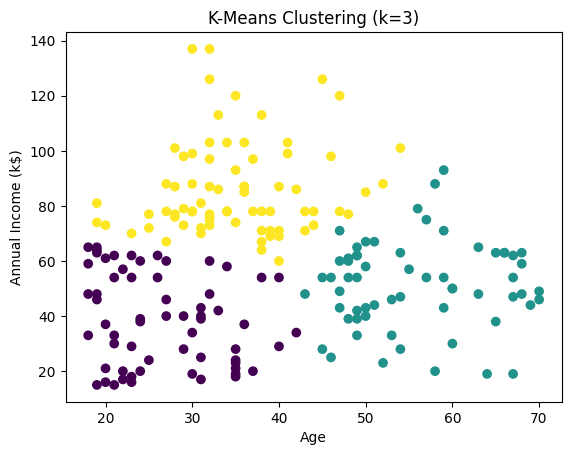

In [ ]:
plt.figure()
plt.scatter(df_out[FEATURE_COLS[0]], df_out[FEATURE_COLS[1]], c=df_out["cluster"])
plt.xlabel(FEATURE_COLS[0])
plt.ylabel(FEATURE_COLS[1])
plt.title(f"K-Means Clustering (k={best_k})")
plt.show()


## 6) Cluster profiling (GroupBy-like summary)

In [ ]:
profile = (
    df_out.groupby("cluster")[FEATURE_COLS]
    .agg(["count", "mean", "median", "min", "max"])
)
profile


Age                           Annual Income (k$)                    \
        count       mean median min max              count       mean median   
cluster                                                                        
0          62  26.661290   24.5  18  42                 62  38.790323   38.5   
1          62  55.806452   54.0  43  70                 62  51.225806   52.0   
2          76  34.960526   34.0  19  54                 76  85.934211   78.0   

                  
        min  max  
cluster           
0        15   65  
1        19   93  
2        60  137

## 7) Save output (optional)

In [ ]:
OUT_PATH = "Lab4_clustered_output.csv"
df_out.to_csv(OUT_PATH, index=False)
print("Saved:", OUT_PATH)


Saved: Lab4_clustered_output.csv
